In [17]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET

def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    raw_frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray.astype(np.float32))
        raw_frames.append(frame)
    
    cap.release()
    return np.array(frames), np.array(raw_frames)


def get_bounding_boxes(mask, min_area=150):

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)

    boxes = []

    for i in range(1, num_labels):

        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        bbox_area = w * h
        fill_ratio = area / (bbox_area + 1e-6)
        aspect_ratio = h / (w + 1e-6)

        if (
            area >= min_area and # minimum area threshold
            fill_ratio > 0.4 and # minimum fill ratio to avoid hollow boxes
            0.4 < aspect_ratio < 2.5 # reasonable aspect ratio for cars
        ):
            boxes.append([x, y, x+w, y+h])

    return boxes

def load_ground_truth(xml_path):

    tree = ET.parse(xml_path)
    root = tree.getroot()

    gt_per_frame = {}

    for track in root.findall("track"):

        for box in track.findall("box"):

            frame = int(box.get("frame"))
            outside = int(box.get("outside"))

            if outside == 1:
                continue

            # ignore parked cars
            parked = False
            for attr in box.findall("attribute"):
                if attr.get("name") == "parked" and attr.text == "true":
                    parked = True

            if parked:
                continue

            xtl = float(box.get("xtl"))
            ytl = float(box.get("ytl"))
            xbr = float(box.get("xbr"))
            ybr = float(box.get("ybr"))

            bbox = [xtl, ytl, xbr, ybr]

            if frame not in gt_per_frame:
                gt_per_frame[frame] = []

            gt_per_frame[frame].append(bbox)

    return gt_per_frame 

def compute_iou(boxA, boxB):

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])

    union = boxAArea + boxBArea - interArea

    return interArea / union if union > 0 else 0

def collect_detections(all_pred_boxes, train_end):

    detections = []

    for i, boxes in enumerate(all_pred_boxes):

        original_frame = train_end + i

        for box in boxes:
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)

            detections.append({
                "frame": original_frame,
                "bbox": box,
                "confidence": area  # using area as ranking score
            })

    return detections

def compute_ap(detections, gt_per_frame, iou_threshold=0.5):

    # sort detections by confidence (descending)
    detections = sorted(detections, key=lambda x: x["confidence"], reverse=True)

    tp = []
    fp = []

    # track matched GT boxes per frame
    matched_gt = {frame: np.zeros(len(boxes)) 
                  for frame, boxes in gt_per_frame.items()}

    total_gt = sum(len(v) for v in gt_per_frame.values())

    for det in detections:

        frame = det["frame"]
        pred_box = det["bbox"]

        gt_boxes = gt_per_frame.get(frame, [])

        best_iou = 0
        best_idx = -1

        for i, gt_box in enumerate(gt_boxes):

            iou = compute_iou(pred_box, gt_box)

            if iou > best_iou:
                best_iou = iou
                best_idx = i

        if best_iou >= iou_threshold:

            if matched_gt[frame][best_idx] == 0:
                tp.append(1)
                fp.append(0)
                matched_gt[frame][best_idx] = 1
            else:
                tp.append(0)
                fp.append(1)
        else:
            tp.append(0)
            fp.append(1)

    tp = np.cumsum(tp)
    fp = np.cumsum(fp)

    recalls = tp / (total_gt + 1e-6)
    precisions = tp / (tp + fp + 1e-6)

    # 11-point interpolation (Pascal VOC)
    ap = 0
    for r in np.linspace(0, 1, 11):
        p = precisions[recalls >= r]
        if len(p) == 0:
            ap += 0
        else:
            ap += np.max(p)

    ap /= 11

    return ap, precisions, recalls

def evaluate_ap50(all_pred_boxes, gt_xml_path, train_end):

    gt_per_frame = load_ground_truth(gt_xml_path)

    detections = collect_detections(all_pred_boxes, train_end)

    ap, precisions, recalls = compute_ap(detections, gt_per_frame, 0.5)

    return ap, precisions, recalls

import json

def gt_to_coco(gt_per_frame, train_end, num_test_frames,
               height=1080, width=1920,
               output_json="gt_coco.json"):

    coco_dict = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "car"}]
    }

    ann_id = 1

    # 🔹 Add ALL test images
    for i in range(num_test_frames):

        frame_id = train_end + i

        coco_dict["images"].append({
            "id": int(frame_id),
            "width": width,
            "height": height,
            "file_name": f"{frame_id}.jpg"
        })

        # If GT exists for that frame, add annotations
        if frame_id in gt_per_frame:

            for box in gt_per_frame[frame_id]:

                x1, y1, x2, y2 = box
                w = x2 - x1
                h = y2 - y1

                coco_dict["annotations"].append({
                    "id": ann_id,
                    "image_id": int(frame_id),
                    "category_id": 1,
                    "bbox": [float(x1), float(y1), float(w), float(h)],
                    "area": float(w*h),
                    "iscrowd": 0
                })
                ann_id += 1

    with open(output_json, "w") as f:
        json.dump(coco_dict, f)

    return output_json

import json

def preds_to_coco(all_pred_boxes, train_end, output_json="preds_coco.json"):

    coco_preds = []

    for i, boxes in enumerate(all_pred_boxes):

        image_id = int(train_end + i)

        for box in boxes:

            x1, y1, x2, y2 = box

            x1 = float(x1)
            y1 = float(y1)
            w  = float(x2 - x1)
            h  = float(y2 - y1)

            coco_preds.append({
                "image_id": image_id,
                "category_id": 1,
                "bbox": [x1, y1, w, h],
                "score": 0.5
            })

    with open(output_json, "w") as f:
        json.dump(coco_preds, f)

    return output_json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def evaluate_coco_ap50(gt_json, pred_json):

    coco_gt = COCO(gt_json)
    coco_dt = coco_gt.loadRes(pred_json)

    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")

    coco_eval.params.iouThrs = np.array([0.5])  # Only IoU=0.5
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats[1]  # AP@0.5

import numpy as np

def remove_nested_boxes(boxes, iou_threshold=0.9):

    keep = []

    for i, boxA in enumerate(boxes):

        x1A, y1A, x2A, y2A = boxA
        areaA = (x2A - x1A) * (y2A - y1A)

        nested = False

        for j, boxB in enumerate(boxes):

            if i == j:
                continue

            x1B, y1B, x2B, y2B = boxB
            areaB = (x2B - x1B) * (y2B - y1B)

            # compute intersection
            xA = max(x1A, x1B)
            yA = max(y1A, y1B)
            xB = min(x2A, x2B)
            yB = min(y2A, y2B)

            interW = max(0, xB - xA)
            interH = max(0, yB - yA)
            interArea = interW * interH

            if interArea >= 0.9 * areaA and areaA < areaB:
                nested = True
                break

        if not nested:
            keep.append(boxA)

    return keep

def compute_iou(boxA, boxB):

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    areaA = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    areaB = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])

    union = areaA + areaB - interArea

    return interArea / (union + 1e-6)


def merge_overlapping_boxes(boxes, iou_threshold=0.3):

    merged = []

    while boxes:

        base = boxes.pop(0)
        bx1, by1, bx2, by2 = base

        to_merge = []

        for box in boxes:
            if compute_iou(base, box) > iou_threshold:
                to_merge.append(box)

        for box in to_merge:
            boxes.remove(box)

            bx1 = min(bx1, box[0])
            by1 = min(by1, box[1])
            bx2 = max(bx2, box[2])
            by2 = max(by2, box[3])

        merged.append([bx1, by1, bx2, by2])

    return merged

In [18]:
#video_path = "/DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/vdo.avi"
video_path = "/ghome/group02/Marina/mcv-c6-2026-team2/Week1/Data/AICity_data/train/S03/c010/vdo.avi"

frames, raw_frames = load_video_frames(video_path)

print("Total frames:", len(frames))

N = len(frames)
train_end = int(0.25 * N)

train_frames = frames[:train_end]
test_frames = frames[train_end:]

raw_test_frames = raw_frames[train_end:]

print("Training frames:", len(train_frames))
print("Testing frames:", len(test_frames))

Total frames: 2141
Training frames: 535
Testing frames: 1606


In [14]:
#roi_img_path = "/DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/roi.jpg"
roi_img_path = "/ghome/group02/Marina/mcv-c6-2026-team2/Week1/Data/AICity_data/train/S03/c010/roi.jpg"
roi = cv2.imread(roi_img_path, cv2.IMREAD_GRAYSCALE)
roi = roi > 0

In [4]:
train_frames = train_frames.astype(np.float32)
test_frames = test_frames.astype(np.float32)

mu = np.mean(train_frames, axis=0)
sigma = np.std(train_frames, axis=0)

alpha = 3.0
foreground_masks = []

for frame in test_frames:

    diff = np.abs(frame - mu)

    sigma_safe = np.maximum(sigma, 1e-6)
    mask = diff >= alpha * (sigma_safe + 2)

    mask = mask & roi
    mask = mask.astype(np.uint8) * 255

    kernel = np.ones((5,5), np.uint8)
    kernel_open = np.ones((3,3), np.uint8)
    kernel_close = np.ones((7,7), np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)
    mask = cv2.dilate(mask, kernel, iterations=1)
    
    foreground_masks.append(mask)

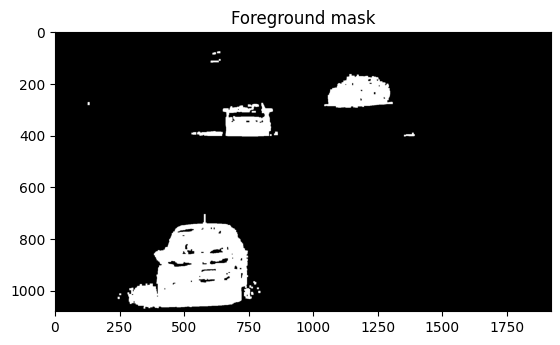

In [5]:
import matplotlib.pyplot as plt

plt.imshow(foreground_masks[20], cmap="gray")
plt.title("Foreground mask")
plt.show()

In [5]:
all_pred_boxes = []

for mask in foreground_masks:
    
    boxes = get_bounding_boxes(mask, min_area=1500)
    boxes = remove_nested_boxes(boxes)
    boxes = merge_overlapping_boxes(boxes)
    
    all_pred_boxes.append(boxes)

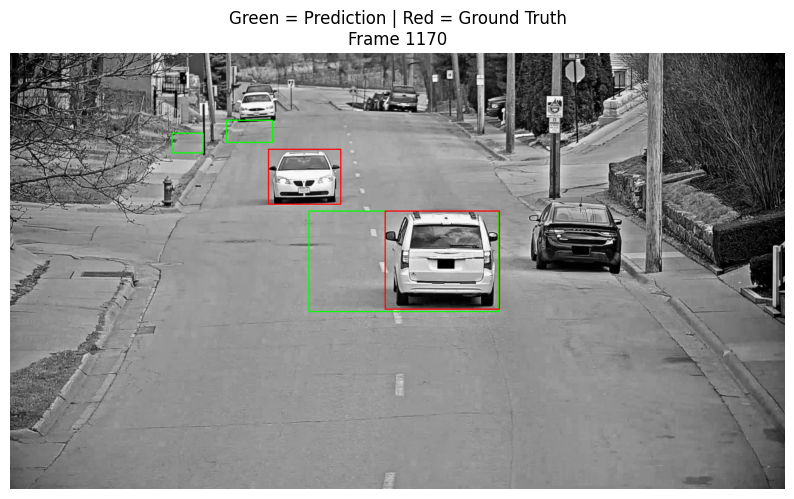

In [6]:
import matplotlib.pyplot as plt
import cv2

gt_xml_path = "//DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/ai_challenge_s03_c010-full_annotation.xml"

# Load GT
gt_per_frame = load_ground_truth(gt_xml_path)

frame_idx = 635

# Align to original video frame index
original_frame = train_end + frame_idx

frame = test_frames[frame_idx].astype(np.uint8)
pred_boxes = all_pred_boxes[frame_idx]
gt_boxes = gt_per_frame.get(original_frame, [])

frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

# 🟢 predictions
for box in pred_boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(frame_color, (x1, y1), (x2, y2), (0,255,0), 2)

# 🔴 ground truth
for box in gt_boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(frame_color, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(10,6))
plt.imshow(frame_color)
plt.title(f"Green = Prediction | Red = Ground Truth\nFrame {original_frame}")
plt.axis("off")
plt.show()

In [ ]:
ap50 = evaluate_coco_ap50(
    gt_to_coco(gt_per_frame, train_end, len(test_frames)),
    preds_to_coco(all_pred_boxes, train_end),
)
print(f"COCO AP50: {ap50:.4f}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=  1 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets= 10 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDe

: 

In [ ]:
import imageio
import os

def create_detection_gif(test_frames,
                         all_pred_boxes,
                         gt_per_frame,
                         train_end,
                         output_path="detections.gif",
                         max_frames=None):

    frames_for_gif = []

    total_frames = len(test_frames)

    if max_frames is not None:
        total_frames = min(total_frames, max_frames)

    print("Generating GIF with", total_frames, "frames...")

    for i in range(total_frames):

        original_frame = train_end + i

        frame = test_frames[i].astype(np.uint8)
        pred_boxes = all_pred_boxes[i]
        gt_boxes = gt_per_frame.get(original_frame, [])

        frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

        # 🟢 Predictions
        for box in pred_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame_color, (x1, y1), (x2, y2), (0,255,0), 2)

        # 🔴 Ground truth
        for box in gt_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame_color, (x1, y1), (x2, y2), (0,0,255), 2)

        # Convert BGR → RGB for imageio
        frame_rgb = cv2.cvtColor(frame_color, cv2.COLOR_BGR2RGB)

        frames_for_gif.append(frame_rgb)

    imageio.mimsave(output_path, frames_for_gif, fps=10)

    print("GIF saved to:", output_path)

create_detection_gif(
    test_frames,
    all_pred_boxes,
    gt_per_frame,
    train_end,
    output_path="detections_full.gif",
    max_frames=100  
)

Generating GIF with 100 frames...
GIF saved to: detections_full.gif
MP4 saved to: detections_full.mp4


sh: 1: ffmpeg: not found


In [ ]:
import itertools
import csv

# --------------------------------------------------
# Segmentation function
# --------------------------------------------------

def segment_and_detect(test_frames, mu, sigma, roi,
                       alpha, min_area,
                       open_size,
                       close_size):

    all_pred_boxes = []

    kernel_open = np.ones((open_size, open_size), np.uint8)
    kernel_close = np.ones((close_size, close_size), np.uint8)

    for frame in test_frames:

        diff = np.abs(frame - mu)
        sigma_safe = np.maximum(sigma, 1e-6)

        mask = diff >= alpha * (sigma_safe + 2)
        mask = mask & roi
        mask = mask.astype(np.uint8) * 255

        # Morphology
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

        boxes = get_bounding_boxes(mask, min_area=min_area)
        all_pred_boxes.append(boxes)

    return all_pred_boxes
# --------------------------------------------------
# GRID SEARCH
# --------------------------------------------------

import itertools
import csv

def run_grid_search(test_frames, mu, sigma, roi,
                    gt_per_frame,
                    train_end,
                    output_csv="grid_results.csv"):

    # Parameter ranges (adjust freely)
    alphas = [2.0, 2.5, 3.0, 3.5, 4.0]
    min_areas = [1500, 1800, 2000, 2200, 2500]
    open_sizes = [1, 3, 5]
    close_sizes = [5, 7, 9]

    results = []

    total_combinations = (
        len(alphas)
        * len(min_areas)
        * len(open_sizes)
        * len(close_sizes)
    )

    print("Total combinations:", total_combinations)

    # 🔹 Build GT COCO ONCE (important)
    gt_json = gt_to_coco(
        gt_per_frame,
        train_end,
        len(test_frames)
    )

    counter = 0

    for alpha, min_area, open_s, close_s in itertools.product(
            alphas, min_areas, open_sizes, close_sizes):

        counter += 1
        print(f"\nRunning {counter}/{total_combinations}")
        print(f"alpha={alpha}, min_area={min_area}, open={open_s}, close={close_s}")

        all_pred_boxes = segment_and_detect(
            test_frames, mu, sigma, roi,
            alpha, min_area,
            open_s, close_s
        )

        pred_json = preds_to_coco(all_pred_boxes, train_end)

        ap50 = evaluate_coco_ap50(gt_json, pred_json)

        print(f"COCO AP50: {ap50:.4f}")

        results.append([
            alpha,
            min_area,
            open_s,
            close_s,
            ap50
        ])

    # Save CSV
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "alpha",
            "min_area",
            "open_size",
            "close_size",
            "AP50"
        ])
        writer.writerows(results)

    print("\nResults saved to", output_csv)

    return results


gt_xml_path = "/DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/ai_challenge_s03_c010-full_annotation.xml"

results = run_grid_search(
    test_frames,
    mu,
    sigma,
    roi,
    gt_per_frame,
    train_end,
    output_csv="task1_grid_search_coco_2nd.csv"
)

In [ ]:
results_sorted = sorted(results, key=lambda x: x[-1], reverse=True)

print("Best configuration:")
print("Alpha:", results_sorted[0][0])
print("Min Area:", results_sorted[0][1])
print("Open Size:", results_sorted[0][2])
print("Close Size:", results_sorted[0][3])
print("Best AP50:", results_sorted[0][4])

Best configuration:
Alpha: 3.0
Min Area: 1500
Open Size: 3
Close Size: 7
Best AP50: 0.27911152572394876
